Informações importantes: 

1- Os valores NaN representam filmes que ainda não foram avaliados pelos usuários.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def getData():
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv('u.data', sep='\t', names=r_cols,
                          encoding='latin-1')
    m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
    movies = pd.read_csv('u.item', sep='|', names=m_cols, usecols=range(5),
                         encoding='latin-1')
    movie_ratings = pd.merge(movies, ratings)
    temp = movie_ratings[['movie_id', 'user_id', 'rating']].copy()
    temp = temp.pivot_table(columns='movie_id', index='user_id', values='rating').copy()
    temp.index = ['User_'+str(int(i)) for i in temp.index]
    temp.columns = ['Filme_'+str(int(i)) for i in temp.columns]
    qtd_cols = 80
    R = temp.iloc[:, :qtd_cols]
    l=[]
    for i in range(1, R.shape[0]+1):
        if R.iloc[i-1, ].isnull().sum() >= (qtd_cols - 10):
            l.append(i)
    R = R.drop(["User_"+str(r) for r in l])
    R.index = ['User_'+str(int(i)) for i in range(R.shape[0])]
    return R

In [4]:
import time

class MatrixFactorization():
    
    def __init__(self, dataframe, K, steps, alpha, beta):
        self.df = dataframe
        self.K = K
        self.steps = steps
        self.alpha = alpha
        self.beta = beta
        
    def fit(self):
        t0 = time.time()
        
        R = self.df.values
        N, M = R.shape
        
        #inicio aleatorio
        P = np.random.rand(N,self.K)
        Q = np.random.rand(self.K,M)
        
        lista_erro_step = []
        
        #loop
        for step in range(self.steps):
            
            mse_total_step = 0
            #varrendo todas as entradas da matriz R
            for i in range(len(R)):
                for j in range(len(R[i])):
                    #validando se o valor associado está preenchido
                    if R[i][j] > 0:

                        #calculando o erro:
                        eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                        mse_total_step += (eij)**2
                        #alterando os valores
                        for k in range(self.K):
                            P[i][k] = P[i][k] + self.alpha * ( 2 * eij * Q[k][j] - self.beta * P[i][k])
                            Q[k][j] = Q[k][j] + self.alpha * ( 2 * eij * P[i][k] - self.beta * Q[k][j])
                            
            lista_erro_step.append(mse_total_step)
            
        self.P = P
        self.Q = Q
        self.lista_erro_step = lista_erro_step
        t1 = time.time()
        print("Fatoração concluída. Tempo aproximado:", int((t1-t0)/60)+1, 'minuto(s).')
        
    def predict(self):
        return self.P.dot(self.Q)
    
    def print_MSE_steps(self):
        plt.figure(figsize=[15,6])
        plt.title("Custo total por Step", fontsize = 16, fontweight = 'bold')
        plt.xlabel("Step", fontsize = 14, fontweight = 'bold')
        plt.ylabel("Erro", fontsize = 14, fontweight = 'bold')
        plt.plot(range(1, 1+self.steps), self.lista_erro_step, c = 'blue', lw = 2)
        plt.grid()
        plt.show()

<br>

Tradicionalmente, para avaliarmos a performance de algoritmos de machine learning, fazemos a divisão dos dados em treino/teste; os dados de teste são utilizados no modelo final, apenas para validar que o mesmo não está sofrendo overfitting e está generalizando bem.

No contexto dos filtros colaborativos, tal divisão dos dados não fará sentido: os métodos discutidos (de filtragem colaborativa) usam as informações de interação dos usuários com itens para "preencher os valores faltantes" da matriz de interação. Esse preenchimento é justamente a recomendação!

<br>

No entanto, podemos aplicar uma __metodologia que "simula" dados de treino/teste.__ 

Essencialmente, essa metodologia consiste de criar uma base de treino em que retiramos algumas interações dos usuários. Dessa forma, os modelos irão aprender os padrões dos dados sem terem acesso a toda informação.

Nos dados de teste, usaremos essas interações retiradas em treino para avaliar os resultados.

<br>

__Considere o exemplo:__

Vamos carregar, novamente, o dataset que usamos ao longo do módulo:

In [5]:
def getDF():
    dic__ = {"User_1":[np.nan, np.nan, np.nan, 1, 7, 2, 3, 8],
         "User_2":[9,10,2,2,6,5,3,8],
         "User_3":[4, 7, 9, 6,6,10,10,2],
         "User_4":[np.nan, 7, 9, 5, 5, 10, 9, 1],
         "User_5":[7.0,6.0,3.0,8.0,3,4.0,3.0, 2],
         "User_6":[np.nan, np.nan, 9, 9,6,8,9,np.nan],
         "User_7":[3,5,4,4,3,3,9,np.nan],
         "User_8":[10,10,10,10,2,2,2,2],
         "User_9":[9,9,np.nan,8,3,3,1,np.nan],
         "User_10":[9,8,10,9,3,4,2,1],
         "User_11":[4,4,3,3,9,9,8,10],
         "User_12":[2,2,4,1,8,10,10,9],
         "User_13":[1,4,1,3,7,10,7,8],
         "User_14":[3,3,2,1,1,10, np.nan,10],
         "User_15":[9,9,8,10,4,2,np.nan,1]
        }
    df = pd.DataFrame(dic__).T
    df.columns = ['Filme_'+str(int(i+1)) for i in range(8)]
    return df

In [6]:
df = getDF()
df

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,NaN,NaN,NaN,1.0,7.0,2.0,3.0,8.0
User_2,9.0,10.0,2.0,2.0,6.0,5.0,3.0,8.0
User_3,4.0,7.0,9.0,6.0,6.0,10.0,10.0,2.0
User_4,NaN,7.0,9.0,5.0,5.0,10.0,9.0,1.0
User_5,7.0,6.0,3.0,8.0,3.0,4.0,3.0,2.0
User_6,NaN,NaN,9.0,9.0,6.0,8.0,9.0,NaN
User_7,3.0,5.0,4.0,4.0,3.0,3.0,9.0,NaN
User_8,10.0,10.0,10.0,10.0,2.0,2.0,2.0,2.0
User_9,9.0,9.0,NaN,8.0,3.0,3.0,1.0,NaN
User_10,9.0,8.0,10.0,9.0,3.0,4.0,2.0,1.0


<br>

Abaixo, criamos o array "ratings", que consiste de nossa matriz de interação usuário/item. No entanto, fizemos um completamento com "0" nos dados faltantes. Dessa forma, o rating = 0 significa que o usuário não avaliou o filme em questão.

<br>

In [6]:
ratings = df.fillna(0).values
ratings

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

<br>

Na sequência, apresentamos a função que faz a divisão dos dados em treino e teste.

<br>

In [8]:
def train_test_split(ratings, qtd):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=qtd, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    return train, test

In [8]:
train, test = train_test_split(ratings, qtd = 2)

<br>

__Vamos comparar os dados de treino e teste com os dados originais:__
    
<br>

In [9]:
#matriz de interação - original;

ratings

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

In [10]:
#dados de treino;
#observe que, para cada usuário (ou seja, para cada linha) 3 notas foram retiradas!! 
#ou seja, foram substituida por 0.

train

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  0.,  5.,  0.,  8.],
       [ 0.,  7.,  9.,  0.,  6., 10., 10.,  2.],
       [ 0.,  7.,  0.,  0.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  0.,  3.,  0.,  3.,  2.],
       [ 0.,  0.,  9.,  0.,  0.,  8.,  9.,  0.],
       [ 3.,  0.,  4.,  4.,  3.,  3.,  0.,  0.],
       [10., 10.,  0., 10.,  2.,  2.,  0.,  2.],
       [ 9.,  9.,  0.,  0.,  3.,  0.,  1.,  0.],
       [ 9.,  0., 10.,  9.,  0.,  4.,  2.,  1.],
       [ 4.,  4.,  0.,  0.,  9.,  9.,  8., 10.],
       [ 2.,  0.,  0.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  0.,  7.,  0.,  7.,  8.],
       [ 0.,  3.,  2.,  1.,  1., 10.,  0.,  0.],
       [ 0.,  9.,  8., 10.,  4.,  0.,  0.,  1.]])

In [11]:
#dados de teste;
#observe que exatamente as notas que foram retiradas de treino são colocadas nessa matriz de teste!!

test

array([[ 0.,  0.,  0.,  0.,  7.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  6.,  0.,  3.,  0.],
       [ 4.,  0.,  0.,  6.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  9.,  5.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  8.,  0.,  4.,  0.,  0.],
       [ 0.,  0.,  0.,  9.,  6.,  0.,  0.,  0.],
       [ 0.,  5.,  0.,  0.,  0.,  0.,  9.,  0.],
       [ 0.,  0., 10.,  0.,  0.,  0.,  2.,  0.],
       [ 0.,  0.,  0.,  8.,  0.,  3.,  0.,  0.],
       [ 0.,  8.,  0.,  0.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  3.,  3.,  0.,  0.,  0.,  0.],
       [ 0.,  2.,  4.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  3.,  0., 10.,  0.,  0.],
       [ 3.,  0.,  0.,  0.,  0.,  0.,  0., 10.],
       [ 9.,  0.,  0.,  0.,  0.,  2.,  0.,  0.]])

<br>

Na prática, usaremos os dados de treino para treinar e escolher os modelos.

Neste caso, podemos, inclusive, fazer a divisão em treino/validação/teste:
    


In [12]:
train, val = train_test_split(train, qtd = 2)

In [13]:
train

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.],
       [ 0., 10.,  2.,  2.,  0.,  5.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  6., 10., 10.,  2.],
       [ 0.,  0.,  0.,  0.,  5., 10.,  0.,  1.],
       [ 0.,  6.,  3.,  0.,  3.,  0.,  0.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  9.,  0.],
       [ 0.,  0.,  4.,  4.,  3.,  0.,  0.,  0.],
       [10.,  0.,  0.,  0.,  2.,  2.,  0.,  2.],
       [ 0.,  0.,  0.,  0.,  3.,  0.,  1.,  0.],
       [ 9.,  0.,  0.,  9.,  0.,  4.,  0.,  1.],
       [ 0.,  4.,  0.,  0.,  0.,  9.,  8., 10.],
       [ 0.,  0.,  0.,  1.,  0., 10., 10.,  9.],
       [ 0.,  4.,  1.,  0.,  7.,  0.,  7.,  0.],
       [ 0.,  3.,  0.,  1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  8.,  0.,  4.,  0.,  0.,  1.]])

In [14]:
val

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  8.],
       [ 9.,  0.,  0.,  0.,  0.,  0.,  0.,  8.],
       [ 0.,  7.,  9.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  7.,  0.,  0.,  0.,  0.,  9.,  0.],
       [ 7.,  0.,  0.,  0.,  0.,  0.,  3.,  0.],
       [ 0.,  0.,  9.,  0.,  0.,  8.,  0.,  0.],
       [ 3.,  0.,  0.,  0.,  0.,  3.,  0.,  0.],
       [ 0., 10.,  0., 10.,  0.,  0.,  0.,  0.],
       [ 9.,  9.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  0.,  0.,  2.,  0.],
       [ 4.,  0.,  0.,  0.,  9.,  0.,  0.,  0.],
       [ 2.,  0.,  0.,  0.,  8.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  8.],
       [ 0.,  0.,  2.,  0.,  0., 10.,  0.,  0.],
       [ 0.,  9.,  0., 10.,  0.,  0.,  0.,  0.]])

In [15]:
test

array([[ 0.,  0.,  0.,  0.,  7.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  6.,  0.,  3.,  0.],
       [ 4.,  0.,  0.,  6.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  9.,  5.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  8.,  0.,  4.,  0.,  0.],
       [ 0.,  0.,  0.,  9.,  6.,  0.,  0.,  0.],
       [ 0.,  5.,  0.,  0.,  0.,  0.,  9.,  0.],
       [ 0.,  0., 10.,  0.,  0.,  0.,  2.,  0.],
       [ 0.,  0.,  0.,  8.,  0.,  3.,  0.,  0.],
       [ 0.,  8.,  0.,  0.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  3.,  3.,  0.,  0.,  0.,  0.],
       [ 0.,  2.,  4.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  3.,  0., 10.,  0.,  0.],
       [ 3.,  0.,  0.,  0.,  0.,  0.,  0., 10.],
       [ 9.,  0.,  0.,  0.,  0.,  2.,  0.,  0.]])

<br>

Observe que, se "juntamos" os dados das 3 tabelas acima, retornamos com os dados originais:
    
<br>

In [16]:
train + val + test

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

In [17]:
(train + val + test) == ratings

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

<br>

Ou seja, com a metodologia acima, temos uma "divisão" dos dados em treino/validação/teste!


Desta forma, podemos usar a metologia padrão de avaliação dos modelos:
    
    - Fitamos os modelos nos dados de treino;
    
    - Avaliamos os modelos nos dados de validação;
    
    - Escolhemos o modelo final, a partir dos resultados de validação;
    
    - Avaliamos o modelo final nos dados de teste.
    
    
<br>


__Ponto de atenção:__

Ao calcularmos as métricas de performance, apenas os valores não nulos dos dados de validação/teste devem ser usados.

<br><br>

Vejamos um exemplo:

In [18]:
fat = MatrixFactorization(dataframe = pd.DataFrame(train, columns = df.columns, index = df.index), 
                          K = 5, steps = 5000, alpha = 0.0001, beta = 0.2)

In [19]:
fat.fit()

Fatoração concluída. Tempo aproximado: 1 minuto(s).


In [20]:
#predição usando apenas os dados de treino!!

pd.DataFrame(fat.predict(), columns = df.columns, index = df.index).round(2)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,3.01,2.10,1.26,1.92,2.17,3.49,2.96,0.22
User_2,6.41,9.52,2.37,1.67,3.38,5.09,7.90,4.37
User_3,10.49,6.13,4.18,6.60,6.15,9.83,9.56,2.21
User_4,6.90,3.57,1.44,3.85,5.50,9.43,6.50,1.13
User_5,5.04,5.85,2.86,2.48,2.93,4.15,5.61,1.98
User_6,9.51,7.17,4.62,5.23,4.24,6.08,8.89,4.51
User_7,6.46,4.94,3.63,4.21,2.80,3.96,6.05,1.71
User_8,9.56,2.26,5.87,8.09,1.95,2.25,6.58,2.06
User_9,1.06,0.34,-0.65,-0.31,2.49,4.31,1.27,1.07
User_10,9.23,0.96,5.98,8.39,3.00,3.92,6.11,0.86


<br>

Veja que a matriz resultante __não é esparsa!__

Dessa forma, como sabemos, podemos utilizá-la para as recomendações.

Como __nosso objetivo no exercício é avaliar performance__, podemos __comparar__ os resultados dessa matriz resultante com os valores dos dados de validação!

In [21]:
pd.DataFrame(val, columns = df.columns, index = df.index)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0
User_2,9.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
User_3,0.0,7.0,9.0,0.0,0.0,0.0,0.0,0.0
User_4,0.0,7.0,0.0,0.0,0.0,0.0,9.0,0.0
User_5,7.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
User_6,0.0,0.0,9.0,0.0,0.0,8.0,0.0,0.0
User_7,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
User_8,0.0,10.0,0.0,10.0,0.0,0.0,0.0,0.0
User_9,9.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
User_10,0.0,0.0,10.0,0.0,0.0,0.0,2.0,0.0


<br>

Agora, irei utilizar o algoritmo de recomendação para encontrar a melhor recomendação possível variando os hiperparametros e analisando as metricas.

In [37]:
R = getData()
print(R.shape)
R

(367, 80)


,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,3.0,4.0,3.0,1.0,4.0,4.0,4.0,1.0,4.0,4.0
User_1,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_2,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
User_3,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,4.0,...,5.0,5.0,3.0,NaN,NaN,NaN,5.0,3.0,4.0,4.0
User_4,4.0,NaN,NaN,4.0,NaN,NaN,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.0,NaN,NaN,3.0,NaN,NaN,4.0,NaN,3.0,NaN,...,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_363,2.0,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_364,4.0,NaN,4.0,NaN,NaN,5.0,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_365,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
ratings = R.fillna(0).values

train, test = train_test_split(ratings=ratings, qtd=2)

In [39]:
train

array([[5., 3., 4., ..., 1., 4., 4.],
       [4., 3., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 3., 0.],
       ...,
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

In [41]:
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 3., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
train, val = train_test_split(ratings=train, qtd=2)

In [43]:
train

array([[5., 0., 4., ..., 1., 4., 4.],
       [0., 3., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 3., 0.],
       ...,
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

In [44]:
val

array([[0., 3., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [45]:
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 3., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
(train + val + test) == ratings

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

validando se o train_test_split está funcionando bem

In [50]:
fat = MatrixFactorization(dataframe = pd.DataFrame(train, columns = R.columns, index = R.index), 
                          K = 5, steps = 5000, alpha = 0.0001, beta = 0.2)
fat.fit()

Fatoração concluída. Tempo aproximado: 12 minuto(s).


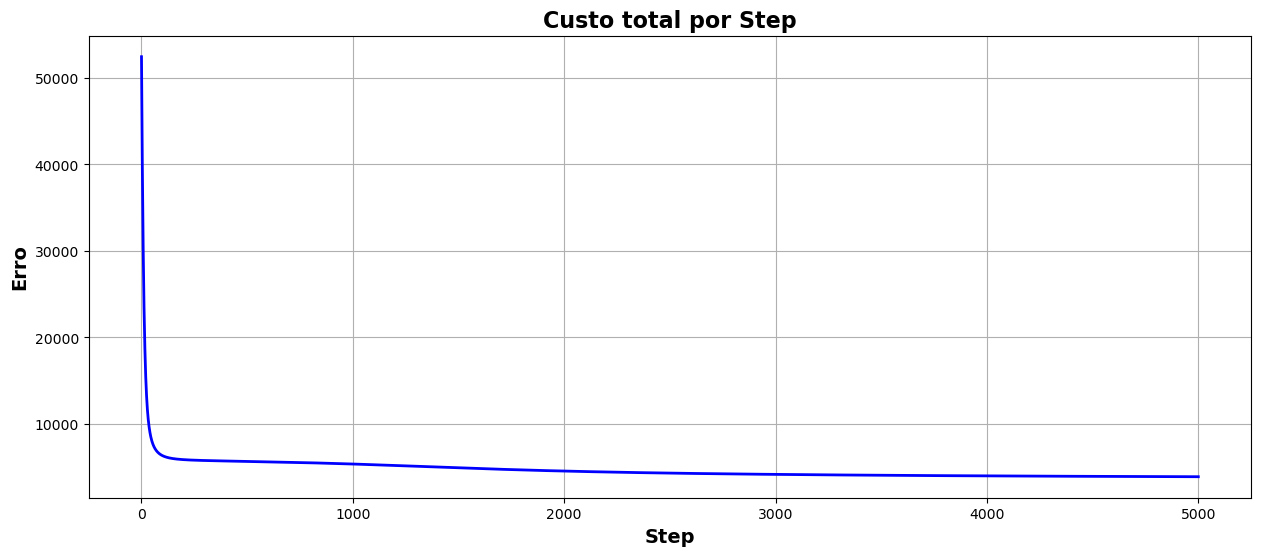

In [51]:
fat.print_MSE_steps()

In [59]:
mse_train = fat.lista_erro_step[len(fat.lista_erro_step)-1]
mse_min = np.min(fat.lista_erro_step)

mse_train == mse_min

True

Avaliando o grafico de "Custo total por Step", vemos que quanto menor a quantidade de steps, menor o erro associado. Ao comparar o ultimo valor da lista_erro_step com menor valor da lista, vemos que realmente quanto maior a quantidade de steps, menor o MSE

In [54]:
fatVal = MatrixFactorization(dataframe = pd.DataFrame(val, columns = R.columns, index = R.index), 
                          K = 5, steps = 5000, alpha = 0.0001, beta = 0.2)
fatVal.fit()

Fatoração concluída. Tempo aproximado: 2 minuto(s).


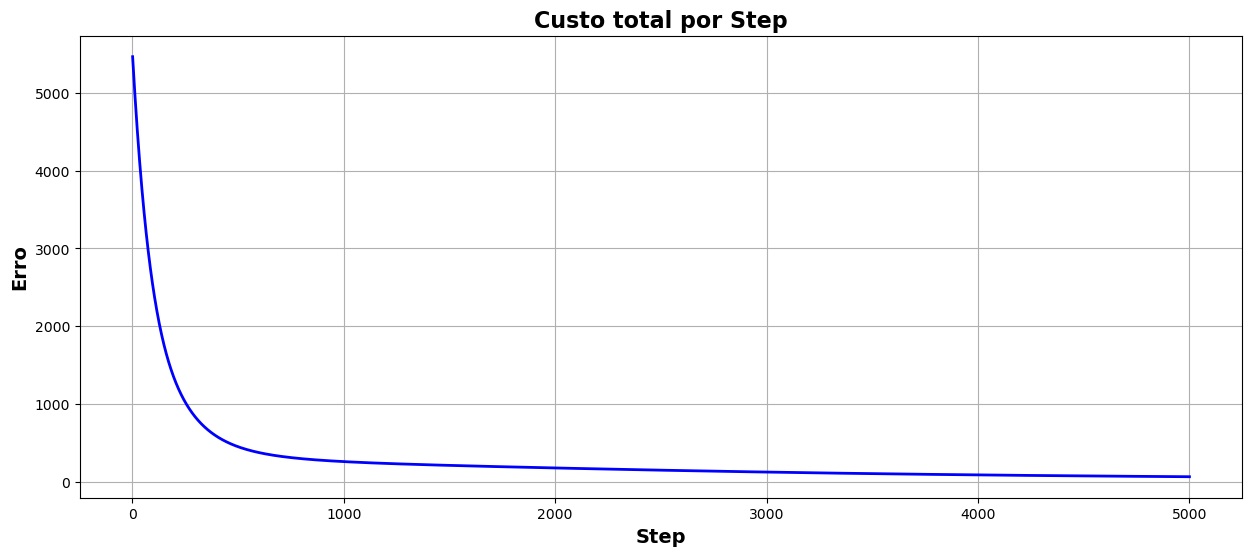

In [57]:
fatVal.print_MSE_steps()

In [62]:
mse_val = fatVal.lista_erro_step[len(fatVal.lista_erro_step)-1]
mse_min = np.min(fatVal.lista_erro_step)

mse_val == mse_min

True

Aqui vemos que o padrão se mantem para os dados de validação. Indicando que steps = 5000 para steps de 1 a 5000 é o valor otimo.

In [64]:
print("Menor MSE de treino:", mse_train)
print("Menor MSE de validação:", mse_val)
print("Comparação entre os dois:", mse_train == mse_val)

Menor MSE de treino: 3907.0015721022273
Menor MSE de validação: 66.46170893682256
Comparação entre os dois: False


Somente para informação: Apesar de ambos os modelos(treino e validação) terem o numero de steps otimo = 5000, os MSEs estão bem diferentes.

In [60]:
fatTest = MatrixFactorization(dataframe = pd.DataFrame(test, columns = R.columns, index = R.index), 
                          K = 5, steps = 5000, alpha = 0.0001, beta = 0.2)
fatTest.fit()

Fatoração concluída. Tempo aproximado: 2 minuto(s).


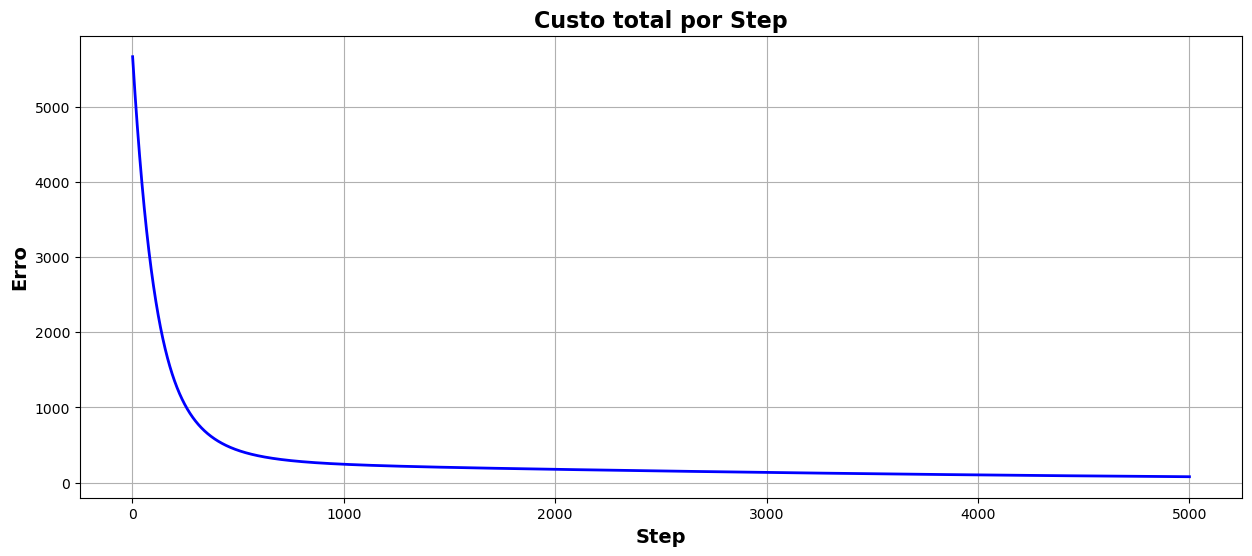

In [65]:
fatTest.print_MSE_steps()

In [66]:
mse_test = fatTest.lista_erro_step[len(fatTest.lista_erro_step)-1]
mse_min = np.min(fatTest.lista_erro_step)

mse_test == mse_min

True

In [67]:
mse_test

77.60691679142576

In [69]:
print("Menor MSE de treino:", mse_train)
print("Menor MSE de validação:", mse_val)
print("Menor MSE de teste:", mse_test)

Menor MSE de treino: 3907.0015721022273
Menor MSE de validação: 66.46170893682256
Menor MSE de teste: 77.60691679142576


Conclusão: Apesar do MSE estar bem diferente dos demais, uma coisa foi constante nos testes, número de steps = 5000 foi o menor MSE possível em ambos os modelos, o que acredito que seja um grande indicativo de que o modelo não está "overfittando". 
Uma explicação que eu possa dar para o MSE de treino estar tao alto em relação aos demais é que diferente do MSE de regressão que faz a media dos valores((y_real - y_pred)/n), o MSE desse modelo faz somente a diferença da matriz real - matriz resultante, entao para explicar isso, precisamos elencar 2 pontos: 

1- Na divisão de treino/validação/teste é retirado valores das matrizes. 

2- Quanto mais valores na matriz que nao sejam zero/nan, maior vai ser o MSE. 

Obs: A metrica não deveria ser chamada de MSE, pois não é feito a media dos valores. Acredito que chama-la somente de ES seria mais apropriado, ja que o M vem de mean/media.

A diferença no tempo de execução do treino ser maior que validação/teste é devido o algoritmo não fazer varios calculos quando o valor da matriz real ser 0, sendo um deles a multiplicação de matrizes, altamente custosa para o processador.

In [75]:
fat_ratings = MatrixFactorization(dataframe = pd.DataFrame(R, columns = R.columns, index = R.index), 
                          K = 5, steps = 5000, alpha = 0.0001, beta = 0.2)
fat_ratings.fit()

Fatoração concluída. Tempo aproximado: 14 minuto(s).


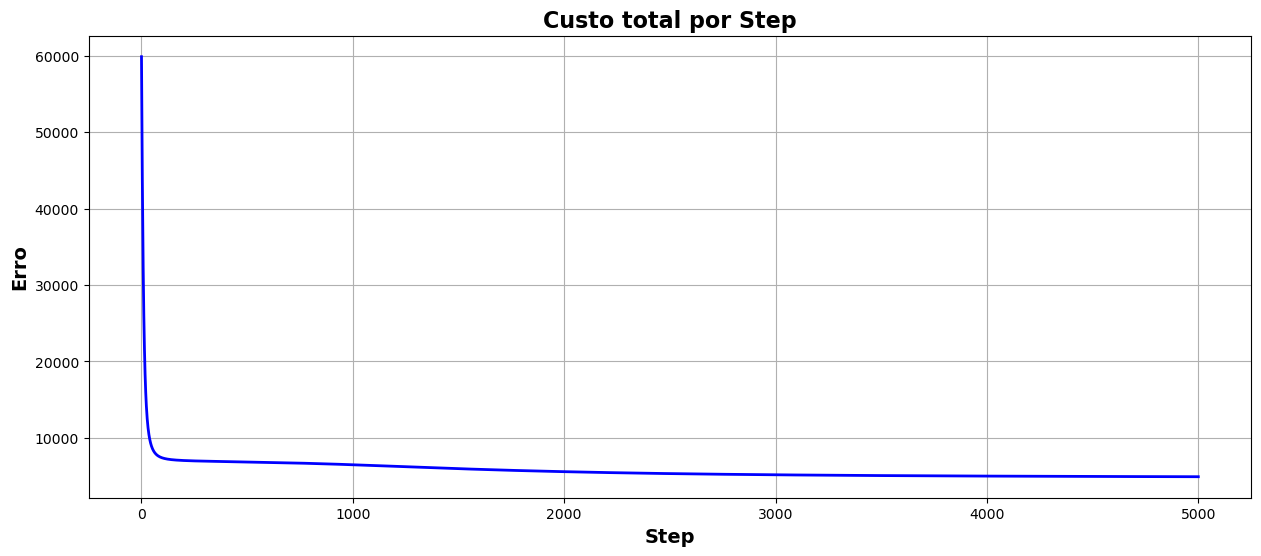

In [81]:
fat_ratings.print_MSE_steps()

In [78]:
mse_ratings = fat_ratings.lista_erro_step[len(fat_ratings.lista_erro_step)-1]
mse_min = np.min(fat_ratings.lista_erro_step)

mse_ratings == mse_min

True

In [80]:
print("Menor MSE da matriz R principal:", mse_ratings)
print("Menor MSE de treino:", mse_train)
print("Menor MSE de validação:", mse_val)
print("Menor MSE de teste:", mse_test)

Menor MSE da matriz R principal: 4908.417312858031
Menor MSE de treino: 3907.0015721022273
Menor MSE de validação: 66.46170893682256
Menor MSE de teste: 77.60691679142576


Usando a matriz R no modelo é possível ver a prova de todos os pontos levandos, como: número de steps ótimo, valor do MSE em relação aos demais modelos e tempo de execução.

Qualquer duvida, fico a disposição. Obrigado.